<a href="https://colab.research.google.com/github/HoanChan/TableVision/blob/main/NoLine_Detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [39]:
#@title Cài đặt kiểm tra môi trường và tải mã nguồn để lấy dữ liệu
# Kiểm tra hiện tại có phải đang ở trong colaboratory hay không
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !git clone https://github.com/HoanChan/TableVision.git TableVision
else:
    print("Running on Local")

Running on Local


<Figure size 1000x2000 with 0 Axes>

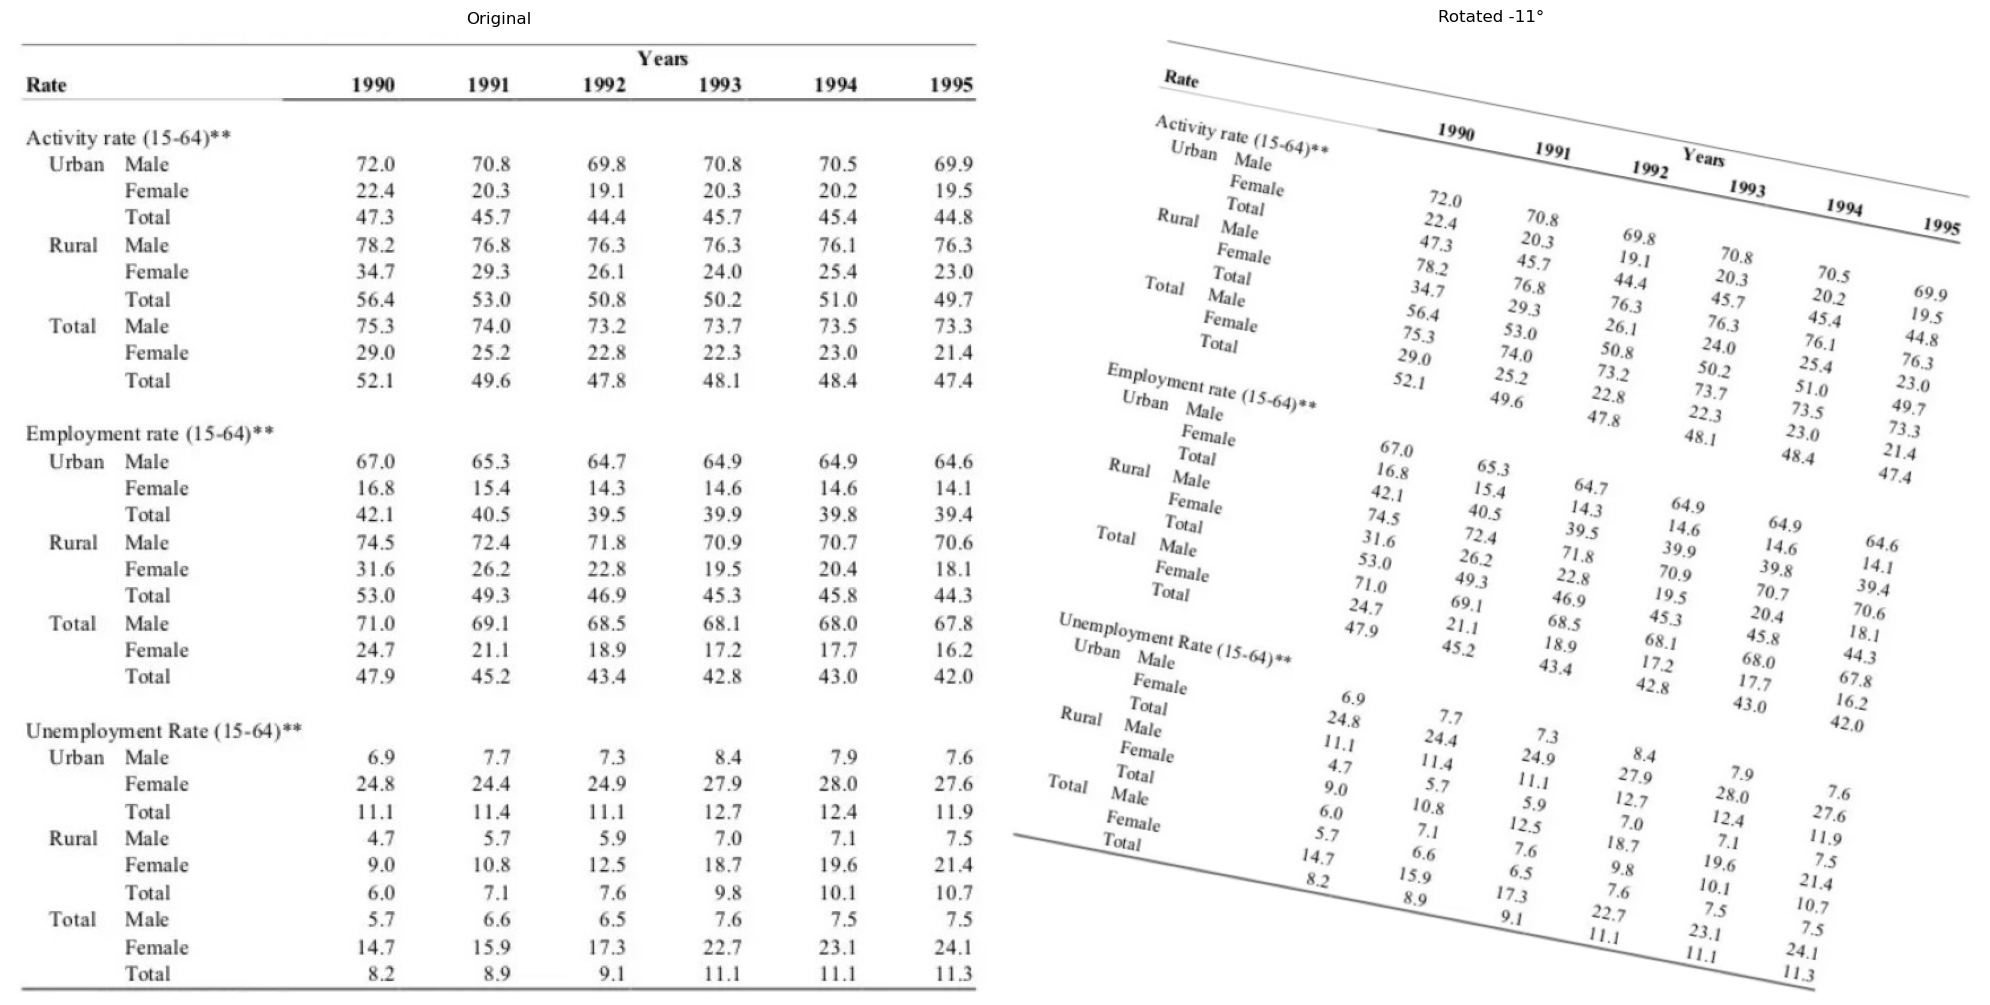

In [40]:
#@title Hàm hiển thị ảnh và xoay ảnh ngẫu nhiên để tạo đầu vào
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
def display_images_with_labels(image_labels, layout, size=(10, 10), show_axis=True):
    """
    Hiển thị các ảnh cùng với nhãn bằng matplotlib.pyplot.

    Tham số:
    - image_labels: Danh sách các tuple (ảnh, nhãn) cần hiển thị.
    - layout: Tuple (rows, columns) chỉ định cách bố trí ảnh trên lưới.
    - size: Tuple (width, height) chỉ định kích thước của mỗi ảnh.
    - show_axis: Bool, xác định xem có hiển thị trục hay không.
    """
    rows, columns = layout
    total_images = len(image_labels)

    # Tính số lượng ảnh cần thêm vào để điền đầy lưới
    num_padding = rows * columns - total_images

    # Thêm ảnh trống vào danh sách nếu cần
    image_labels += [(None, None)] * num_padding

    # Tạo subplot với tỉ lệ cố định
    fig, axes = plt.subplots(rows, columns, figsize=(size[0]*columns, size[1]*rows), subplot_kw={'aspect': 'equal'})

    # Hiển thị ảnh cùng với nhãn trên các ô subplot
    for i, (image, label) in enumerate(image_labels):
        ax = axes.flat[i]
        if image is not None:
            # Chuyển đổi màu từ BGR sang RGB để hiển thị đúng
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
        if label is not None:
            ax.set_title(label)
        if not show_axis:
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    
def rotate_image(image, angle):
    # Xác định kích thước ảnh
    height, width = image.shape[:2]

    # Tính toán ma trận xoay
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)

    # Tính toán kích thước mới của ảnh sau khi xoay
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    # Cập nhật ma trận xoay để điều chỉnh kích thước ảnh
    rotation_matrix[0, 2] += (new_width / 2) - (width / 2)
    rotation_matrix[1, 2] += (new_height / 2) - (height / 2)

    # Thực hiện xoay và điều chỉnh kích thước ảnh
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated_image

prePath = "/content/TableVision/" if IN_COLAB else ""
image_path=prePath + "sample/no4.jpg"
image = cv2.imread(image_path)
# # resize về width = 1000
# scale_percent = 1000 / image.shape[1]
# width = int(image.shape[1] * scale_percent)
# height = int(image.shape[0] * scale_percent)
# image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
# xoay ảnh ngẫu nhiên
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

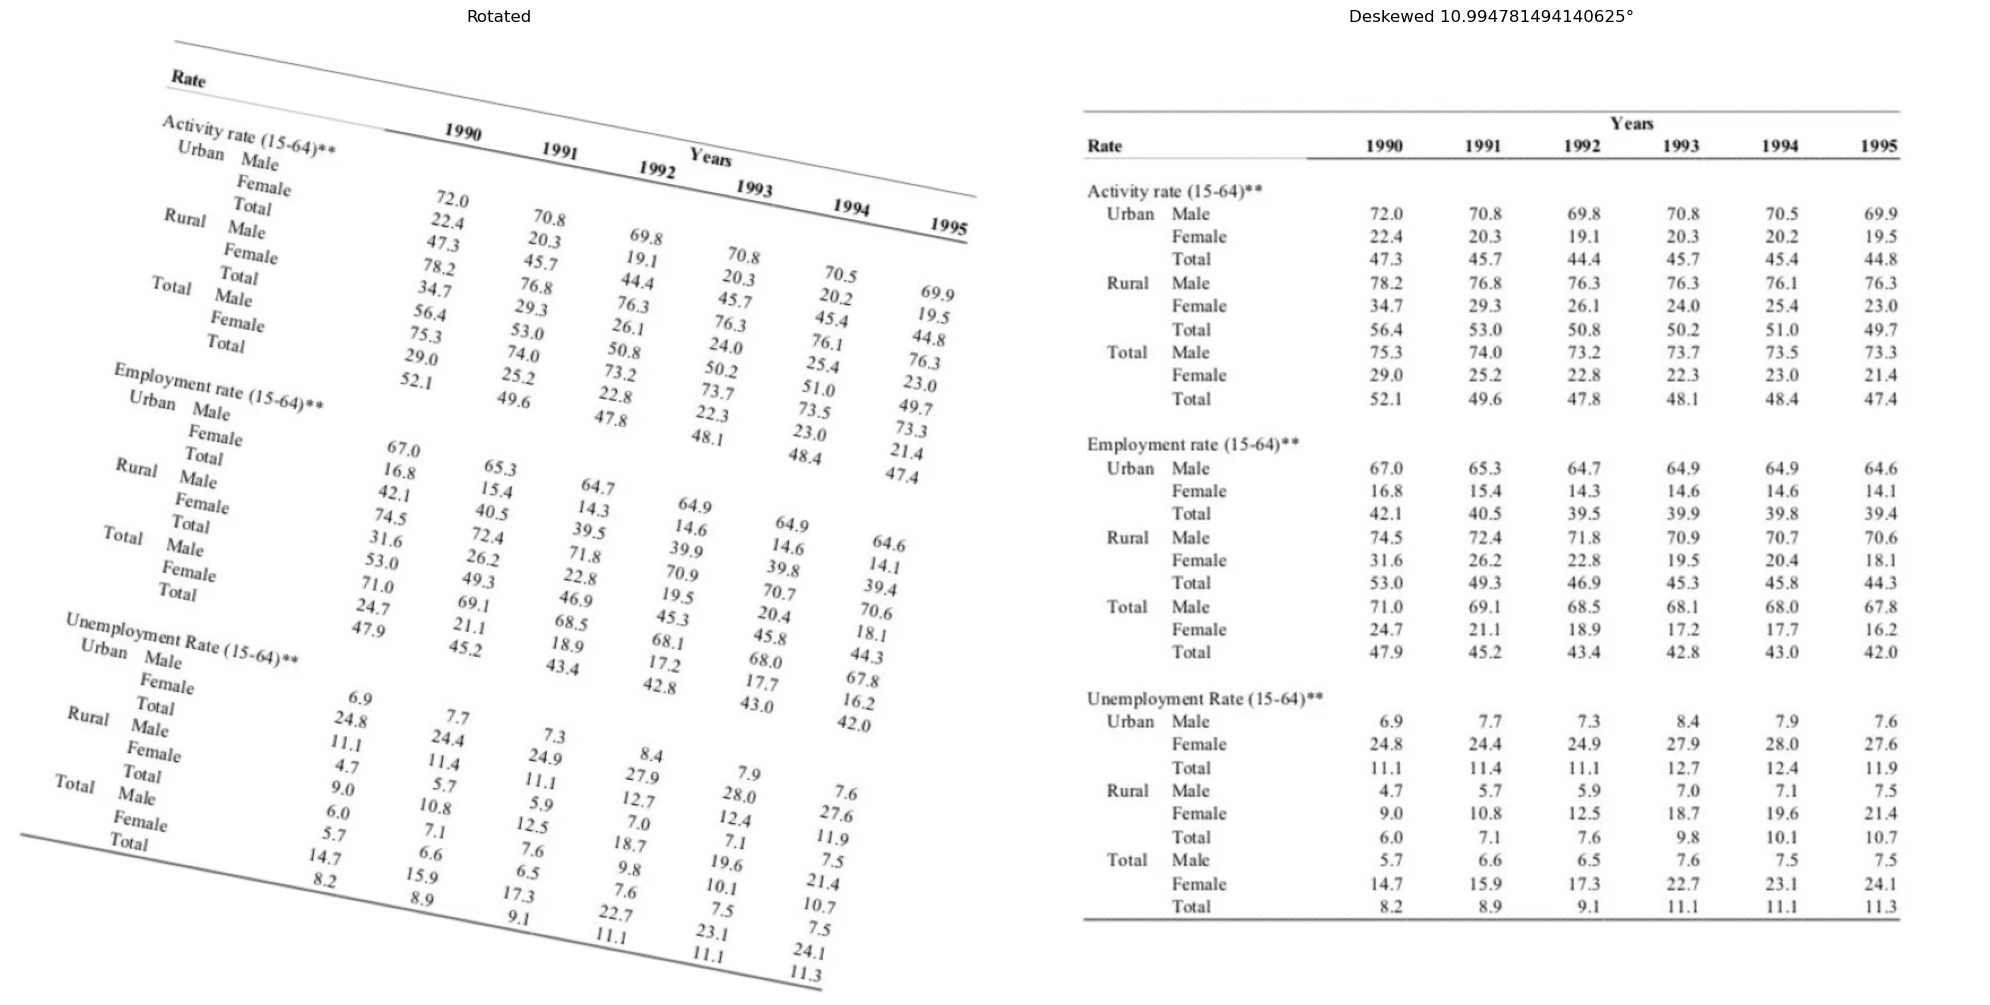

In [41]:
#@title Làm chỉnh sửa góc nghiêng
def deskew_image(image):
    """
    Chỉnh sửa góc nghiêng của ảnh.

    Tham số:
    - image: Ảnh cần chỉnh sửa góc nghiêng.

    Kết quả:
    - deskewed_image: Ảnh đã chỉnh sửa góc nghiêng.
    - angle: Góc nghiêng của ảnh.
    """
    # Làm mờ ảnh để loại bỏ nhiễu
    blur_image = cv2.medianBlur(image, 5)

    # Chuyển đổi sang ảnh grayscale và đảo ngược màu
    grayscale_image = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    # Xác định ngưỡng 
    _, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Tìm tọa độ các điểm ảnh khác 0 (điểm ảnh màu trắng)
    coordinates = np.column_stack(np.where(threshold_image > 0))

    # Xác định góc xoay của ảnh
    angle = cv2.minAreaRect(coordinates)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    # Xoay ảnh để chỉnh sửa góc nghiêng và điều chỉnh kích thước ảnh để xoay không bị cắt ảnh
    height, width = blur_image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image, angle

image_deskew, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_deskew, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

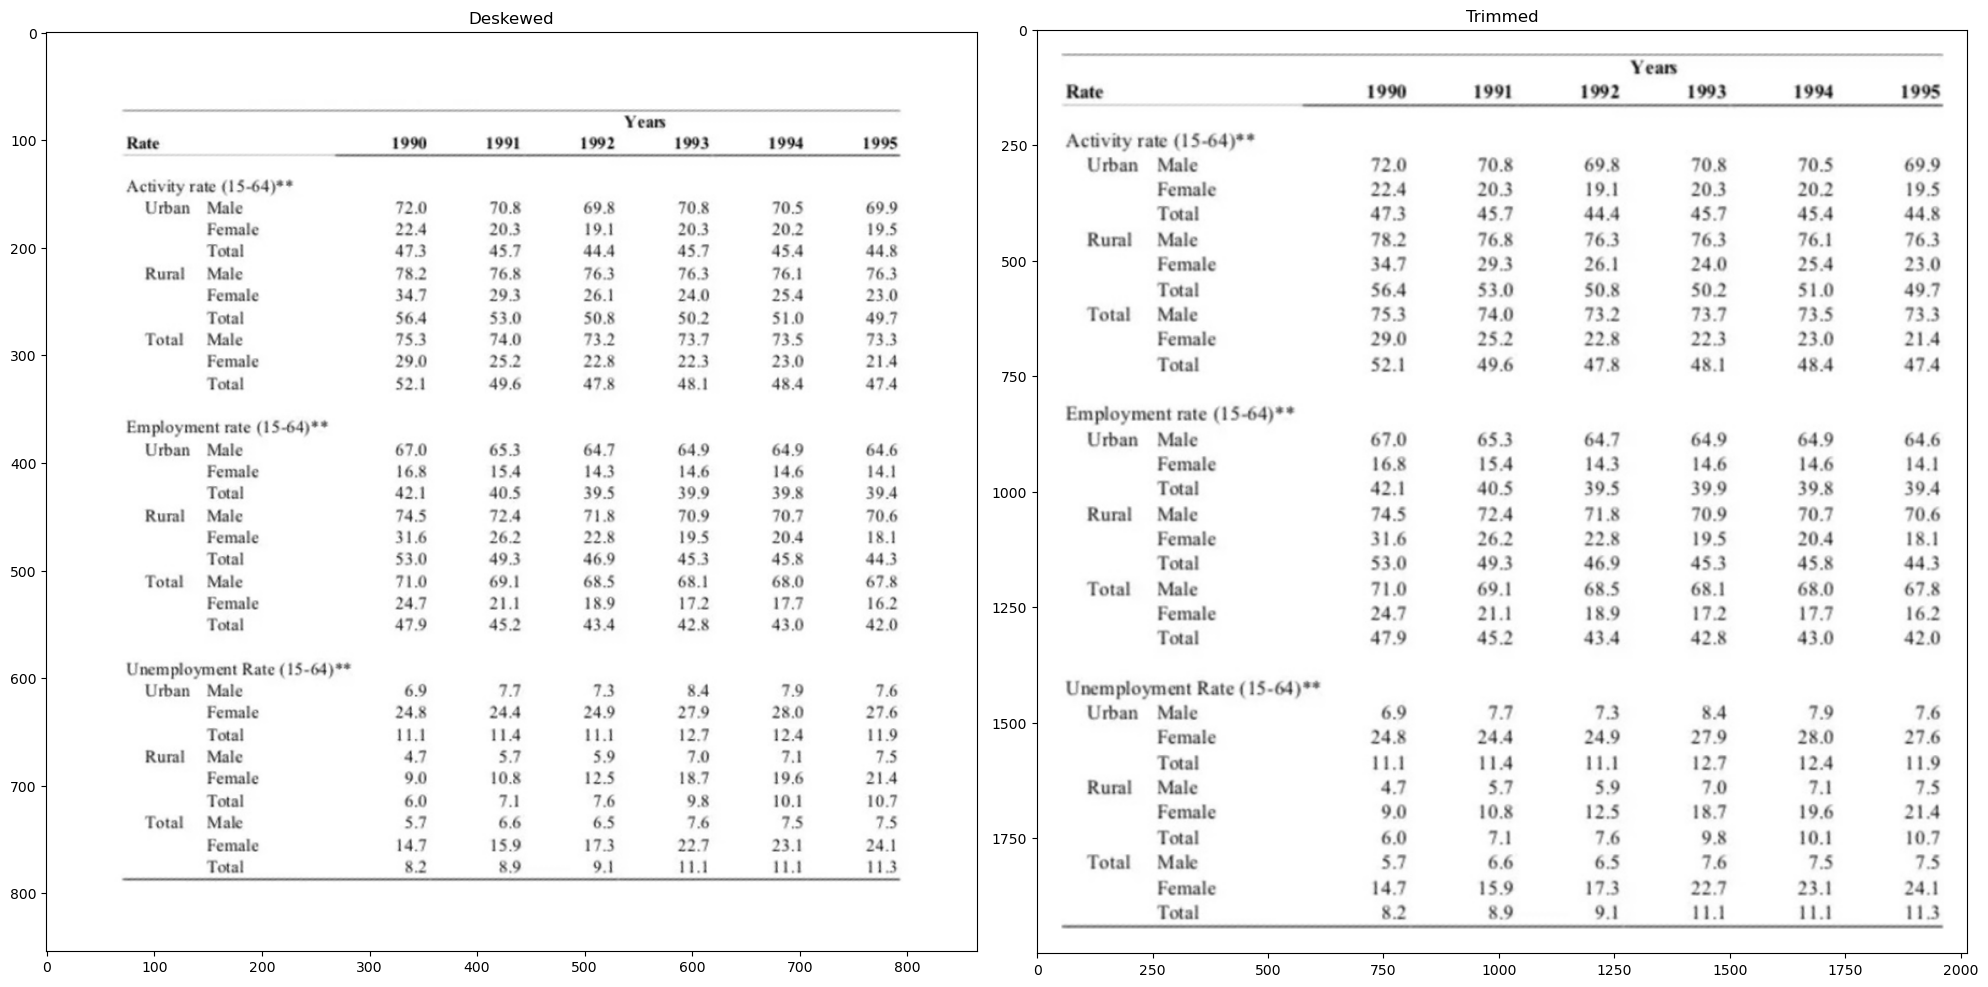

In [42]:
def trim_white(image):
    # Chuyển đổi ảnh sang không gian màu xám
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Áp dụng ngưỡng nhị phân để tạo mask chỉ chứa các điểm ảnh trắng
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Tìm các chỉ số hàng và cột không chứa giá trị 0 (màu trắng) đầu tiên
    rows = np.where(np.any(thresh != 0, axis=1))[0]
    cols = np.where(np.any(thresh != 0, axis=0))[0]

    # Tính toán các giới hạn của bounding box
    y1, y2 = rows[0], rows[-1] + 1
    x1, x2 = cols[0], cols[-1] + 1

    # Cắt và trả về phần ảnh đã được trim
    trimmed_image = image[y1:y2, x1:x2]

    # Thêm 20 pixel vào mỗi cạnh để tránh việc cắt bớt các ký tự
    trimmed_image = cv2.copyMakeBorder(trimmed_image, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    #resize về chiều nhỏ nhất là 1000
    w,h = trimmed_image.shape[:2]
    if w < h:
      scale_percent = 2000 / trimmed_image.shape[0]
    else:
      scale_percent = 2000 / trimmed_image.shape[1]

    width = int(trimmed_image.shape[1] * scale_percent)
    height = int(trimmed_image.shape[0] * scale_percent)
    trimmed_image = cv2.resize(trimmed_image, (width, height), interpolation=cv2.INTER_AREA)

    return trimmed_image

image_ok = trim_white(image_deskew)
display_images_with_labels([(image_deskew, "Deskewed"), (image_ok, "Trimmed")], (1, 2), show_axis=True)

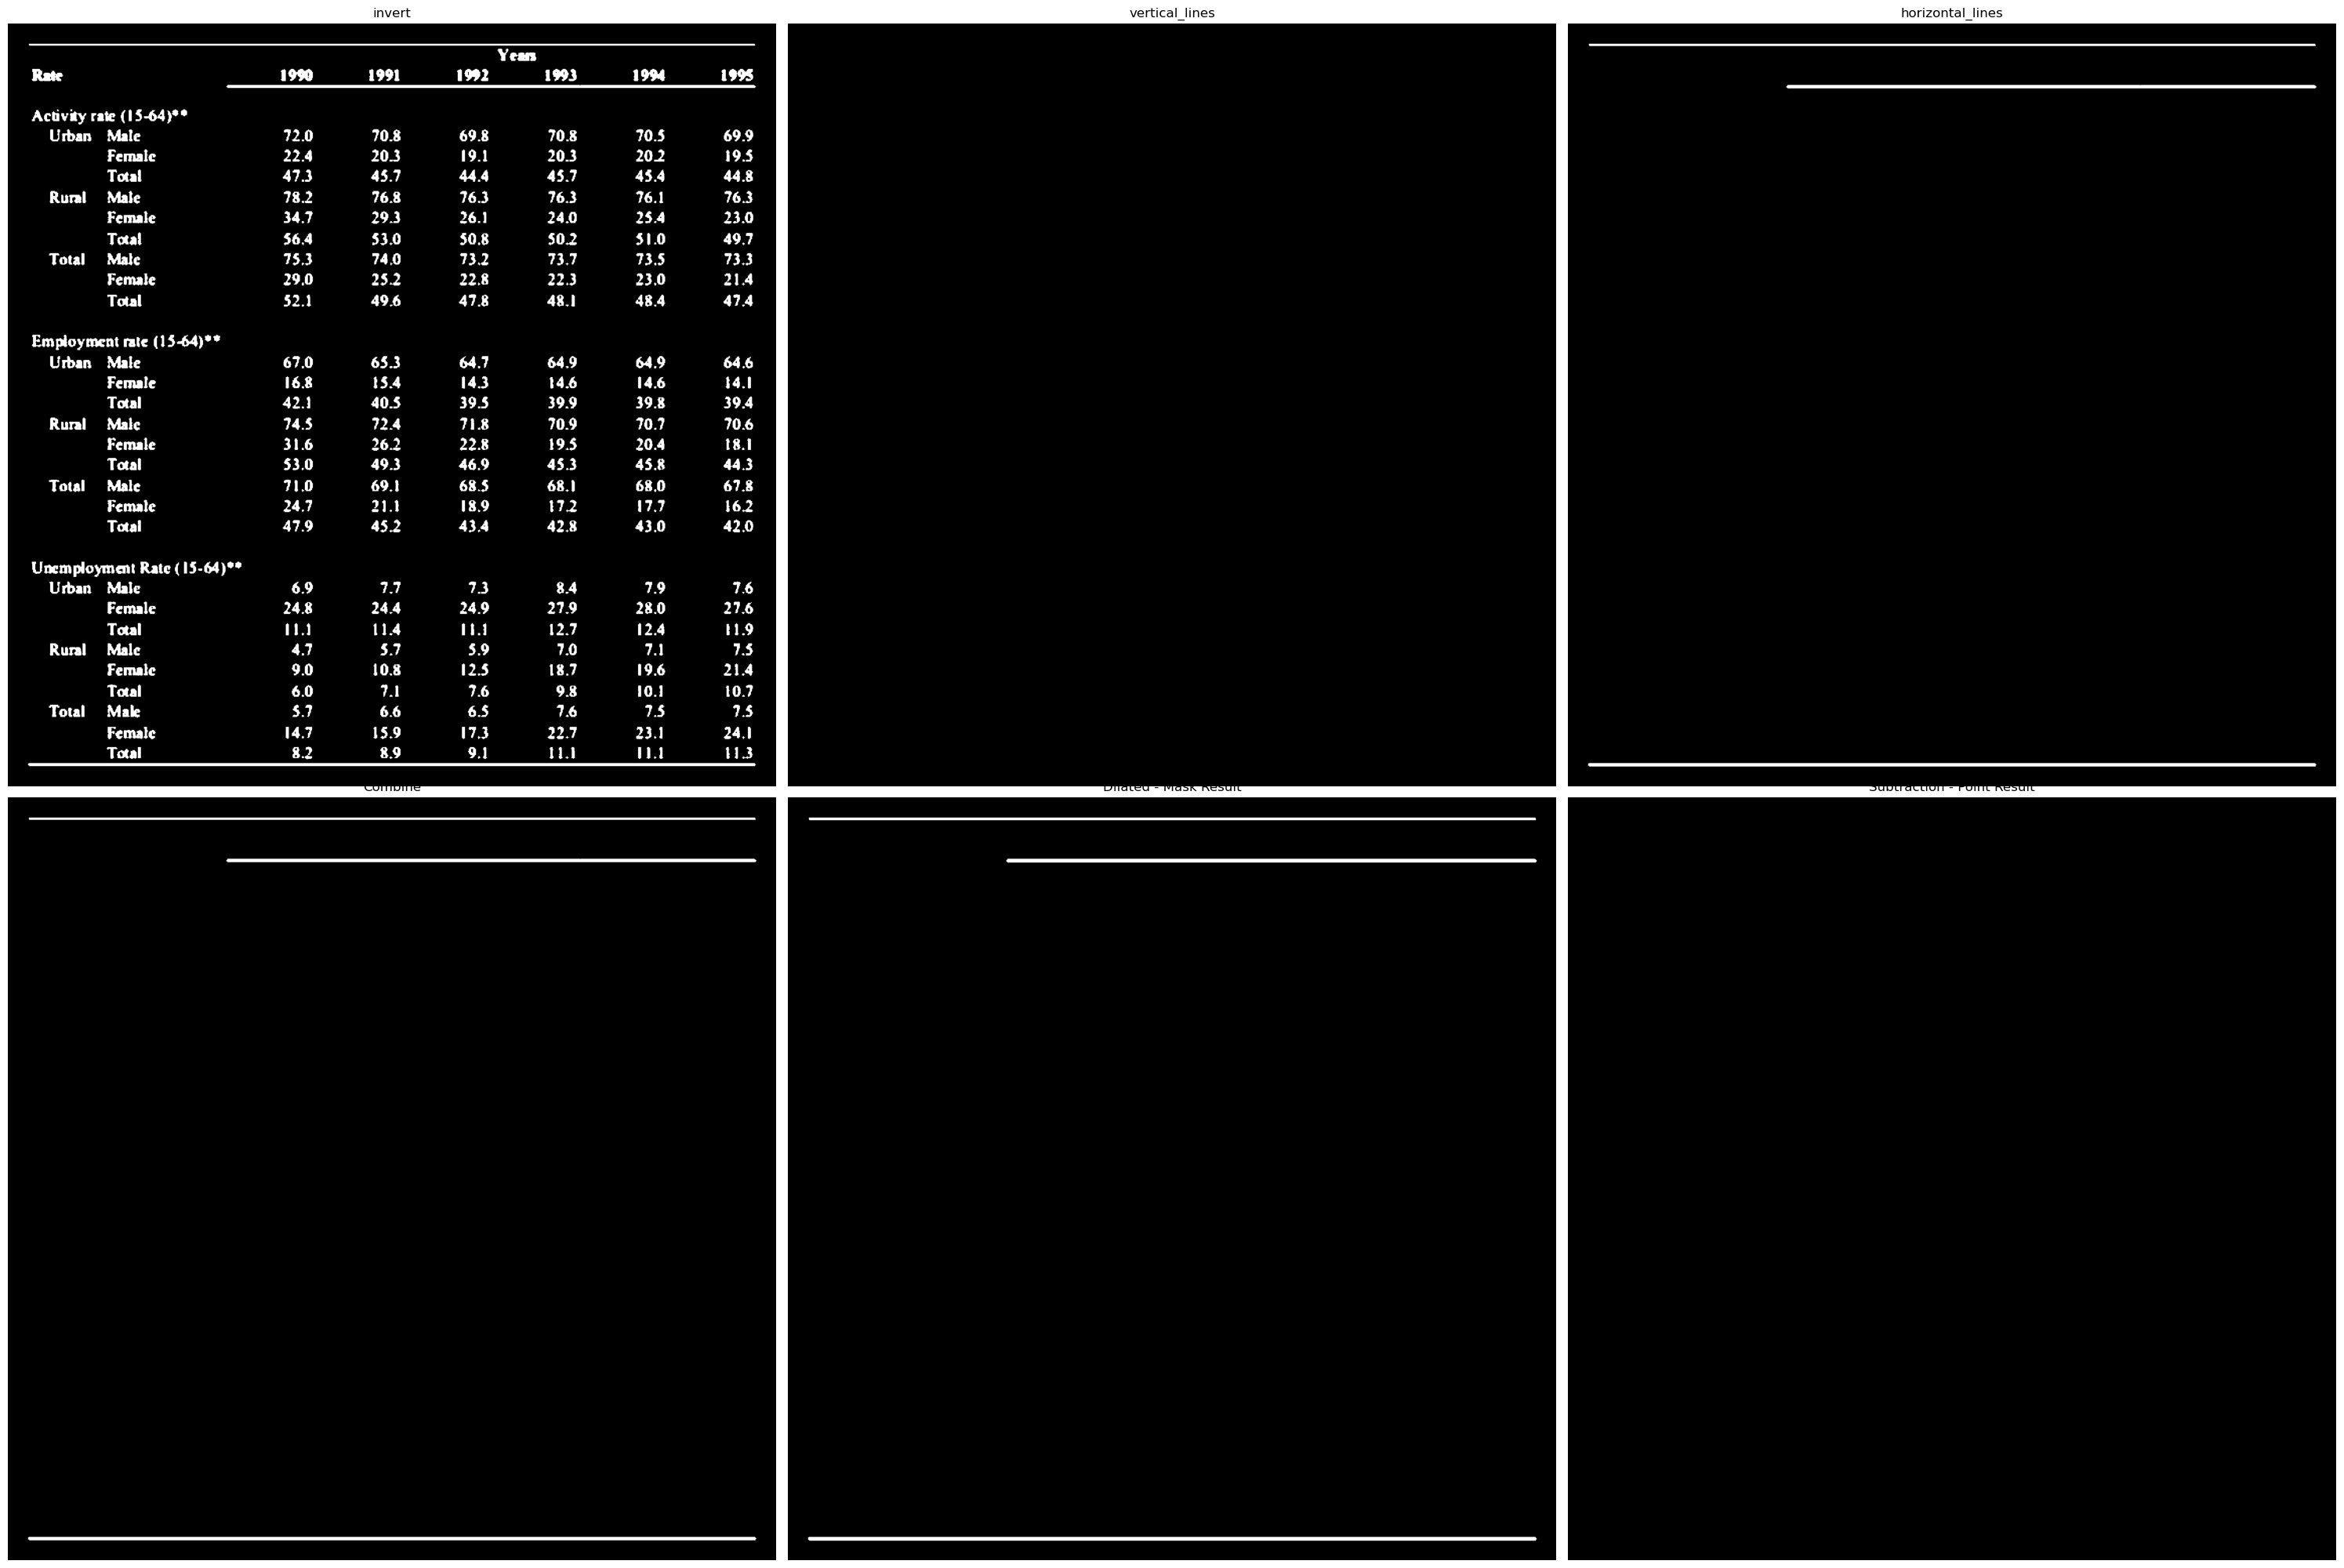

In [43]:
#@title Nhận diện cấu trúc bảng

def detect_lines(img_bin, fixkernel, detectkernel):
    """
    Phát hiện các đường thẳng trong ảnh bằng cách sử dụng các kernel được chỉ định.
    Cụ thể, ảnh được lấp đầy các khoảng trống với fixkernel.
    Sau đó loại bỏ các thành phần không phải đường thẳng với detectkernel.
    Cuối cùng là phục hồi lại như cũ với detectkernel.

    Tham số:
    - img_bin: Ảnh nhị phân.
    - fixkernel: Kernel được sử dụng để dilate (Bồi đắp các pixel màu trắng) để sửa lỗi.
    - detectkernel: Kernel được sử dụng để erode (Bào mòn các pixel màu trắng) và dilate nhằm giữ lại các đường.

    Kết quả:
    - result: Ảnh sau khi phát hiện các đường thẳng.
    """
    image_0 = cv2.dilate(img_bin, fixkernel, iterations=1)
    image_1 = cv2.erode(image_0, detectkernel, iterations=3)
    result = cv2.dilate(image_1, detectkernel, iterations=3)
    return result

def find_Lines(img):
    """
    Nhận diện cấu trúc bảng trong ảnh.

    Tham số:
    - img: Ảnh cần nhận diện cấu trúc.

    Kết quả:
    - img_vh: Ảnh chứa thông tin về các đường kẻ dọc và ngang (mask).
    - img_sub: Ảnh chứa thông tin các điểm giao nhau của các đường dọc và ngang.
    - outImag: Danh sách các ảnh trung gian.
    """    
    outImag=[]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_height, img_width = img.shape
    # THRESH_OTSU là phương pháp tự động xác định ngưỡng dựa trên histogram của ảnh
    thresh, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    outImag.append((img_bin, 'invert'))

    # Giả sử bảng có tối đa 50 dòng và 30 cột
    kernel_len_ver = img_height // 50
    kernel_len_hor = img_width // 30
    # Defining a vertical kernel to detect all vertical lines of image
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len_ver))

    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_hor, 1))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    vertical_lines = detect_lines(img_bin, kernel, ver_kernel)
    outImag.append((vertical_lines, 'vertical_lines'))

    horizontal_lines = detect_lines(img_bin, kernel, hor_kernel)
    outImag.append((horizontal_lines, 'horizontal_lines'))

    img_vh = cv2.bitwise_or(vertical_lines, horizontal_lines)
    outImag.append((img_vh, 'Combine'))

    img_vh = cv2.dilate(img_vh, kernel, iterations=1)
    outImag.append((img_vh, 'Dilated - Mask Result'))

    img_sub = cv2.bitwise_and(vertical_lines, horizontal_lines)
    outImag.append((img_sub, 'Subtraction - Point Result'))

    return img_vh, img_sub, outImag

mask, dots, outImag = find_Lines(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

In [44]:
#@title Loại bỏ các vùng không cần thiết (cụ thể ở đây chính là các đường kẻ dọc và ngang) - Để cắt các ô bảng
def remove_regions(image, mask):
    """
    Loại bỏ các vùng trong ảnh sử dụng mặt nạ.

    Tham số:
    - image: Ảnh gốc.
    - mask: Mặt nạ có kích thước giống với ảnh, với giá trị 0 ở các vùng cần loại bỏ và 1 ở các vùng khác.

    Trả về:
    - Ảnh đã loại bỏ các vùng cần loại bỏ.
    """
    masked_image = image.copy()
    masked_image[mask != 0] = [255, 255, 255]
    return masked_image

image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (mask,'Mask'), (image_removed, "Removed")], (1, 3), show_axis=False)

In [45]:
# Vẽ văn bản vào trung tâm của các box (ở đây là cell)
def draw_text_in_center(img, text, box):
    x1, y1, x2, y2 = box

    center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    text_width = text_size[0]
    text_height = text_size[1]
    text_origin = (center[0] - text_width // 2, center[1] + text_height // 2)

    cv2.putText(img, text, text_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)

In [46]:
def min_with_default(arr, default = 0):
    try: return np.min(arr)
    except: return default

def max_with_default(arr, default = 0):
    try: return np.max(arr)
    except: return default

def is_bbox_overlap(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    if x2_2 < x1_1: return False # Kiểm tra xem bbox2 có nằm bên trái bbox1 hay không
    if x1_2 > x2_1: return False # Kiểm tra xem bbox2 có nằm bên phải bbox1 hay không
    if y2_2 < y1_1: return False # Kiểm tra xem bbox2 có nằm phía trên bbox1 hay không
    if y1_2 > y2_1: return False # Kiểm tra xem bbox2 có nằm phía dưới bbox1 hay không
    return True # Nếu không thoả mãn các điều kiện trên, hai bbox chồng lên nhau

def is_bboxs_overlap(box, bboxs):
    for bbox in bboxs:
        if is_bbox_overlap(box, bbox):
            return True
    return False

def isSameRow(bbox1, bbox2, overlap_percent = 50 ):
    min_height = min(bbox1[3] - bbox1[1], bbox2[3] - bbox2[1])
    overlap_height = min(bbox1[3], bbox2[3]) - max(bbox1[1], bbox2[1])
    return overlap_height / min_height * 100 >= overlap_percent

def isSameCol(bbox1, bbox2, overlap_percent = 50):
    min_width = min(bbox1[2] - bbox1[0], bbox2[2] - bbox2[0])
    overlap_width = min(bbox1[2], bbox2[2]) - max(bbox1[0], bbox2[0])
    return overlap_width / min_width * 100 >= overlap_percent

def is_bbox_inside(bbox1, bbox2):
    # Kiểm tra xem bbox1 có nằm trong bbox2 hay không
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    return x1_1 >= x1_2 and y1_1 >= y1_2 and x2_1 <= x2_2 and y2_1 <= y2_2

def is_bbox_outside(bbox1, bbox2):
    return not is_bbox_overlap(bbox2, bbox1)

def merge_bbox(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return (x1, y1, x2, y2)

def create_bbox(boxs):
    x1 = min([box[0] for box in boxs])
    y1 = min([box[1] for box in boxs])
    x2 = max([box[2] for box in boxs])
    y2 = max([box[3] for box in boxs])
    return (x1, y1, x2, y2)

def get_same_row_col_bboxs(bbox, bboxs, mode = 'row', overlap_percent = 0):
    # Tìm tất cả các bbox cùng hàng với bbox sao cho bbox bao toàn bộ chúng không chồng lên bbox khác
    boxs = []
    others = []
    isSame = isSameRow if mode == 'row' else isSameCol
    for box in bboxs:
        if isSame(bbox, box, overlap_percent):
            boxs.append(box)
        else:
            others.append(box)
    bbox = create_bbox(boxs)
    # Lọc ra các bbox không cùng cột nhưng lại chồng lên bbox
    others = [box for box in others if is_bbox_overlap(bbox, box)]
    # duyệt qua others
    for box in others:
        # duyệt qua boxs theo thứ tự ngược
        for i in range(len(boxs) - 1, -1, -1):
            if isSame(box, boxs[i], overlap_percent):
                boxs.pop(i)
    return boxs

def create_mask_from_bboxs(image, bboxs):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for bbox in bboxs:
        x1, y1, x2, y2 = bbox
        mask[y1:y2, x1:x2] = 255
    return mask

def explain_bboxs_by_width(bboxs, image, row_threshold = 20):
    width, height = image.shape[:2]
    # duyệt từng bbox, mở rộng bbox theo chiều ngang cho tới khi sắp chạm vào bbox bên cạnh hoặc biên
    for index in range(len(bboxs)):
        bbox = bboxs[index]
        bbox_width = bbox[2] - bbox[0]
        # Lập danh sách các bbox cùng cột với nó
        same_column_bboxs = get_same_row_col_bboxs(bbox, bboxs, mode='col', overlap_percent=0)
        # ratio_threshold = 2
        # same_column_bboxs = [box for box in same_column_bboxs if (box[2] - box[0]) / bbox_width  <= ratio_threshold]
        x1_min = np.min([box[0] for box in same_column_bboxs])
        x2_max = np.max([box[2] for box in same_column_bboxs])        
        # thay đổi x1 và x2 của bbox hiện tại sao cho nằm trong cột và không chạm vào bbox bên cạnh
        x2_max_left = max_with_default([box[2] for box in bboxs if box[2] + row_threshold < x1_min], x1_min)
        x1_min = max(x1_min, x2_max_left)
        
        x1_min_right = min_with_default([box[0] for box in bboxs if box[0] > x2_max + row_threshold], x2_max)
        x2_max = min(x2_max, x1_min_right)

        # cập nhật lại bbox
        bboxs[index] = (x1_min, bbox[1], x2_max, bbox[3])
    return bboxs

def explain_bboxs_by_column(bboxs, image, row_threshold = 20):
    width, height = image.shape[:2]
    # duyệt từng bbox, mở rộng bbox theo chiều ngang theo cột
    checker = [False] * len(bboxs)
    for index in range(len(bboxs)):
        if checker[index]: continue
        bbox = bboxs[index]
        x1_min = bbox[0]
        x2_max = bbox[2]
        # Mở rộng bbox sang trái
        x2_max_left = max_with_default([box[2] for box in bboxs if box[2] + row_threshold//2 < x1_min])
        if x2_max_left == 0 :
            x1_min = row_threshold
        elif x2_max_left < x1_min - row_threshold:
            x1_min = (x1_min + x2_max_left)//2
           
        # Mở rộng bbox sang phải
        x1_min_right = min_with_default([box for box in bboxs if box[0] > x2_max + row_threshold//2])
        if x1_min_right == 0:
            x2_max = width - row_threshold
        else:
            x2_max = max(x2_max, x1_min_right - row_threshold)
        
        # cập nhật lại bbox
        same_column_bboxs = [(i, box) for i, box in enumerate(bboxs) if isSameCol(bbox, box) and checker[i] == False]
        for i, box in same_column_bboxs:
            bboxs[i] = (x1_min, box[1], x2_max, box[3])
            checker[i] = True
    return bboxs

def explain_bboxs_by_space(bboxs, image, row_threshold = 20, col_threshold = 20):
    width, height = image.shape[:2]
    # tìm tất cả bbox mà không có bbox nào ở bên phải và cùng hàng với nó rồi mở rộng nó, nếu có thể thì mở rộng về cả 2 phía luôn
    no_right_bboxs = [box for box in bboxs if len([box2 for box2 in bboxs if isSameRow(box, box2, overlap_percent=0) and box2[0] > box[2]]) == 0]
    for index in range(len(bboxs)):
        if bboxs[index] in no_right_bboxs:
            x1, y1, x2, y2 = bboxs[index]
            explain_right_width = width - x2 - row_threshold            
            new_box = (max(row_threshold, x1 - explain_right_width), y1, x2 + explain_right_width, y2)           
            # Điều chỉnh lại x1 cho đúng cột
            same_column_bboxs = [box for box in bboxs if isSameCol(new_box, box, overlap_percent=0) and box != bboxs[index]]
            new_box = (min_with_default([box[0] for box in same_column_bboxs], new_box[0]), y1, x2 + explain_right_width, y2)
            same_row_bboxs = [box for box in bboxs if isSameRow(bboxs[index], box, overlap_percent=0) and box != bboxs[index]]          
            isOverlap = is_bboxs_overlap(new_box, same_row_bboxs)
            if not isOverlap:
                bboxs[index] = create_bbox([bboxs[index], new_box])
            else:
                bboxs[index] = create_bbox([bboxs[index], (x1, y1, width - row_threshold, y2)])
    # tìm tất cả các bbox có các bbox cùng hàng nằm cách xa nó 1 khoảng lớn hơn ngưỡng rồi mở rộng nó
    right_bboxs = [(box, min_with_default([box2[0] for box2 in bboxs if isSameRow(box, box2) and box2[0] > box[2]])) for box in bboxs] 
    far_right_bboxs = [(box, min) for box, min in right_bboxs if min > box[2] + row_threshold * 2]
    for index in range(len(bboxs)):
        for far_right_bbox, min in far_right_bboxs:
            if bboxs[index] == far_right_bbox:
                bboxs[index] = create_bbox([bboxs[index], (bboxs[index][0], bboxs[index][1], min - row_threshold, bboxs[index][3])])
    # tìm tất cả các bbox mà không có bbox nào ở bên dưới và cùng cột với nó rồi mở rộng nó
    no_bottom_bboxs = [box for box in bboxs if len([box2 for box2 in bboxs if isSameCol(box, box2) and box2[1] > box[3]]) == 0]
    for index in range(len(bboxs)):
        if bboxs[index] in no_bottom_bboxs:
            bboxs[index] = create_bbox([bboxs[index], (bboxs[index][0], bboxs[index][1], bboxs[index][2], height - col_threshold*2)])
    # tìm tất cả các bbox có các bbox cùng cột nằm cách xa nó 1 khoảng lớn hơn ngưỡng rồi mở rộng nó
    bottom_bboxs = [(box, min_with_default([box2[1] for box2 in bboxs if isSameCol(box, box2) and box2[1] > box[3]])) for box in bboxs]
    far_bottom_bboxs = [(box, min) for box, min in bottom_bboxs if min > box[3] + col_threshold * 2]
    for index in range(len(bboxs)):
        for far_bottom_bbox, min in far_bottom_bboxs:
            if bboxs[index] == far_bottom_bbox:
                bboxs[index] = create_bbox([bboxs[index], (bboxs[index][0], bboxs[index][1], bboxs[index][2], min - col_threshold)])
    # tìm tất cả các bbox không có bbox nào ở trên nó và cùng cột với nó rồi mở rộng nó
    no_top_bboxs = [box for box in bboxs if len([box2 for box2 in bboxs if isSameCol(box, box2) and box2[3] < box[1]]) == 0]
    for index in range(len(bboxs)):
        if bboxs[index] in no_top_bboxs:
            bboxs[index] = create_bbox([bboxs[index], (bboxs[index][0], col_threshold, bboxs[index][2], bboxs[index][3])])
    return bboxs

def normalize_bboxs(bboxs, row_threshold = 10, col_threshold = 10):
    # Duyệt qua từng bbox
    for index in range(len(bboxs)):
        # tìm tất cả các bbox cùng hàng với nó
        min_x1 = np.min([box[0] for box in bboxs if abs(bboxs[index][0] - box[0]) < row_threshold])
        min_y1 = np.min([box[1] for box in bboxs if abs(bboxs[index][1] - box[1]) < col_threshold])
        max_x2 = np.max([box[2] for box in bboxs if abs(box[2] - bboxs[index][2]) < row_threshold])
        max_y2 = np.max([box[3] for box in bboxs if abs(box[3] - bboxs[index][3]) < col_threshold])
        bboxs[index] = (min_x1, min_y1, max_x2, max_y2)
    return bboxs

def bbox_area(bbox):
    x1, y1, x2, y2 = bbox
    return (x2 - x1) * (y2 - y1)

def find_Cells(image):    
    """
    Nhận diện cấu trúc bảng trong ảnh.

    Tham số:
    - image: Ảnh cần nhận diện cấu trúc.

    Kết quả:
    - img_vh: Ảnh chứa thông tin về các đường kẻ dọc và ngang (mask).
    - img_sub: Ảnh chứa thông tin các điểm giao nhau của các đường dọc và ngang.
    - outImag: Danh sách các ảnh trung gian.
    """    
    outImag=[]
    # outImag.append((image, 'image'))
    img_height, img_width = image.shape[:2]
    if img_height == 0 or img_width == 0:
        return [], [], image, outImag
    # THRESH_OTSU là phương pháp tự động xác định ngưỡng dựa trên histogram của ảnh
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # outImag.append((img_bin, 'invert'))
    try:
        img_median = cv2.medianBlur(img_bin, 11)
    except:
        img_median = img_bin
    outImag.append((img_median, 'img_median'))

    
    # Connect letters that are connected only by a few pixels
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
    img_connect = cv2.dilate(img_median, kernel, iterations=3)
    outImag.append((img_connect, 'connect_letters'))

    # loại bỏ nhiễu
    img_bold = cv2.medianBlur(img_connect, 9)
    outImag.append((img_bold, 'medianBlur'))

    # Xác định các contours
    contours, hierarchy = cv2.findContours(img_bold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Sắp xếp các contours theo vị trí từ trên xuống dưới, từ trái qua phải
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1] * img_width + cv2.boundingRect(ctr)[0]) 

    bboxs = [cv2.boundingRect(contour) for contour in contours]
    # chuyển sang x1, y1, x2, y2
    bboxs = [(x, y, x+w, y+h) for x, y, w, h in bboxs]
    
    mask = create_mask_from_bboxs(img_bold, bboxs)
    outImag.append((draw_bboxs(mask, bboxs), 'mask'))
    
    bboxs = explain_bboxs_by_width(bboxs, mask)
    mask = create_mask_from_bboxs(img_bold, bboxs)
    outImag.append((draw_bboxs(mask, bboxs), 'explain by width'))

    # Loại bỏ các bbox chồng lấp nhau (loại bỏ bbox nhỏ hơn)
    small_bboxs = [(i,bbox) for i, bbox in enumerate(bboxs) if len([box for box in bboxs if is_bbox_overlap(bbox, box) and bbox != box and bbox_area(bbox) < bbox_area(box)]) > 0]
    bboxs = [bbox for i, bbox in enumerate(bboxs) if i not in [index for index, bbox in small_bboxs]]
    
    # bboxs = explain_bboxs_by_column(bboxs, mask)
    # mask = create_mask_from_bboxs(img_bold, bboxs)
    # outImag.append((draw_bboxs(mask, bboxs), 'explain by columns'))

    bboxs = explain_bboxs_by_space(bboxs, mask)
    mask = create_mask_from_bboxs(img_bold, bboxs)
    outImag.append((draw_bboxs(mask, bboxs), 'explain by space'))

    bboxs = normalize_bboxs(bboxs)
    mask = create_mask_from_bboxs(img_bold, bboxs)
    outImag.append((draw_bboxs(mask, bboxs), 'normalize bboxs'))
    
    # Sắp xếp các bboxs theo vị trí từ trên xuống dưới, từ trái qua phải
    bboxs = sorted(bboxs, key=lambda box: box[1] * img_width + box[0])
    
    return bboxs, mask, outImag

def draw_bboxs(image, bboxs, texts = lambda x: str(x)):    
    img_width = image.shape[1]
    # Sắp xếp các bboxs theo vị trí từ trên xuống dưới, từ trái qua phải
    bboxs = sorted(bboxs, key=lambda box: box[1] * img_width + box[0])    
    img_bboxs = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # vẽ bboxs
    for index, box in enumerate(bboxs, start=1):
        cv2.rectangle(img_bboxs, box[:2], box[2:], (0, 255, 0), 3)
        draw_text_in_center(img_bboxs, texts(index), box)
    return img_bboxs

bboxs, mask, outImag = find_Cells(image_removed)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

In [47]:
def split_rows_columns(centers, mode='row'):
    mode = 0 if mode == 'row' else 1
    centers.sort(key=lambda c: c[1-mode])  # Sắp xếp centers theo tọa độ y hoặc x tùy theo mode
    rows_columns = []
    current_row_column = [centers[0]]
    for center in centers[1:]:
        if abs(center[1-mode] - current_row_column[0][1-mode]) <= 10:  # Điểm y hoặc x gần nhau thuộc cùng một hàng hoặc cột
            current_row_column.append(center)
        else:  # Điểm y hoặc x xa, tạo hàng hoặc cột mới
            rows_columns.append(current_row_column)
            current_row_column = [center]
    rows_columns.append(current_row_column)  # Thêm hàng/cột cuối cùng
    # Sắp xếp lại các center trong mỗi hàng/cột theo tọa độ x hoặc y tùy theo mode
    for row_column in rows_columns:
        row_column.sort(key=lambda c: c[mode])
    return rows_columns

def split_box_rows_columns(bboxs, mode='row'):
    mode = 0 if mode == 'row' else 1
    bboxs.sort(key=lambda c: c[1-mode])  # Sắp xếp bboxs theo tọa độ y hoặc x tùy theo mode
    rows_columns = []
    current_row_column = [bboxs[0]]
    for box in bboxs[1:]:
        if (mode ==0 and isSameRow(box,current_row_column[0])) or (mode !=0 and isSameCol(box, current_row_column[0])):  # Điểm y hoặc x gần nhau thuộc cùng một hàng hoặc cột
            current_row_column.append(box)
        else:  # Điểm y hoặc x xa, tạo hàng hoặc cột mới
            rows_columns.append(current_row_column)
            current_row_column = [box]
    rows_columns.append(current_row_column)  # Thêm hàng/cột cuối cùng

    # Xử lý trường hợp rowspan/colspan 
    for row_column in rows_columns:
        tops = [box[:2] for box in row_column]
        cols = split_rows_columns(tops, 'row' if mode == 0 else 'col')
        # thay thế row_column bằng các phần tử của cols
        index = rows_columns.index(row_column)
        # lập danh sách các box dựa vào tops
        box_cols = [[box for box in row_column if box[:2] in col] for col in cols]
        if len(box_cols) > 1:
            # xóa row_column hiện tại
            rows_columns = rows_columns[:index] + box_cols + rows_columns[index+1:]
       
    # Sắp xếp lại các box trong mỗi hàng/cột theo tọa độ x hoặc y tùy theo mode
    for row_column in rows_columns:
        row_column.sort(key=lambda c: c[1-mode])
    return rows_columns

def getbox_index(box, rows, cols):
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            if box in row and box in col:
                return i, j
    return -1, -1
boxs = bboxs
cols = split_box_rows_columns(boxs, mode = 'col')       
rows = split_box_rows_columns(boxs, mode = 'row')
box_indexs = [getbox_index(box, rows, cols) for box in boxs]
new_mask = create_mask_from_bboxs(image_removed, boxs)
img_rows_cols = draw_bboxs(new_mask, boxs, lambda x: str(x) + ' '+ str(box_indexs[x-1]))
display_images_with_labels([(mask,'bbox'),(img_rows_cols, 'rows cols')], (1, 2), show_axis=False)

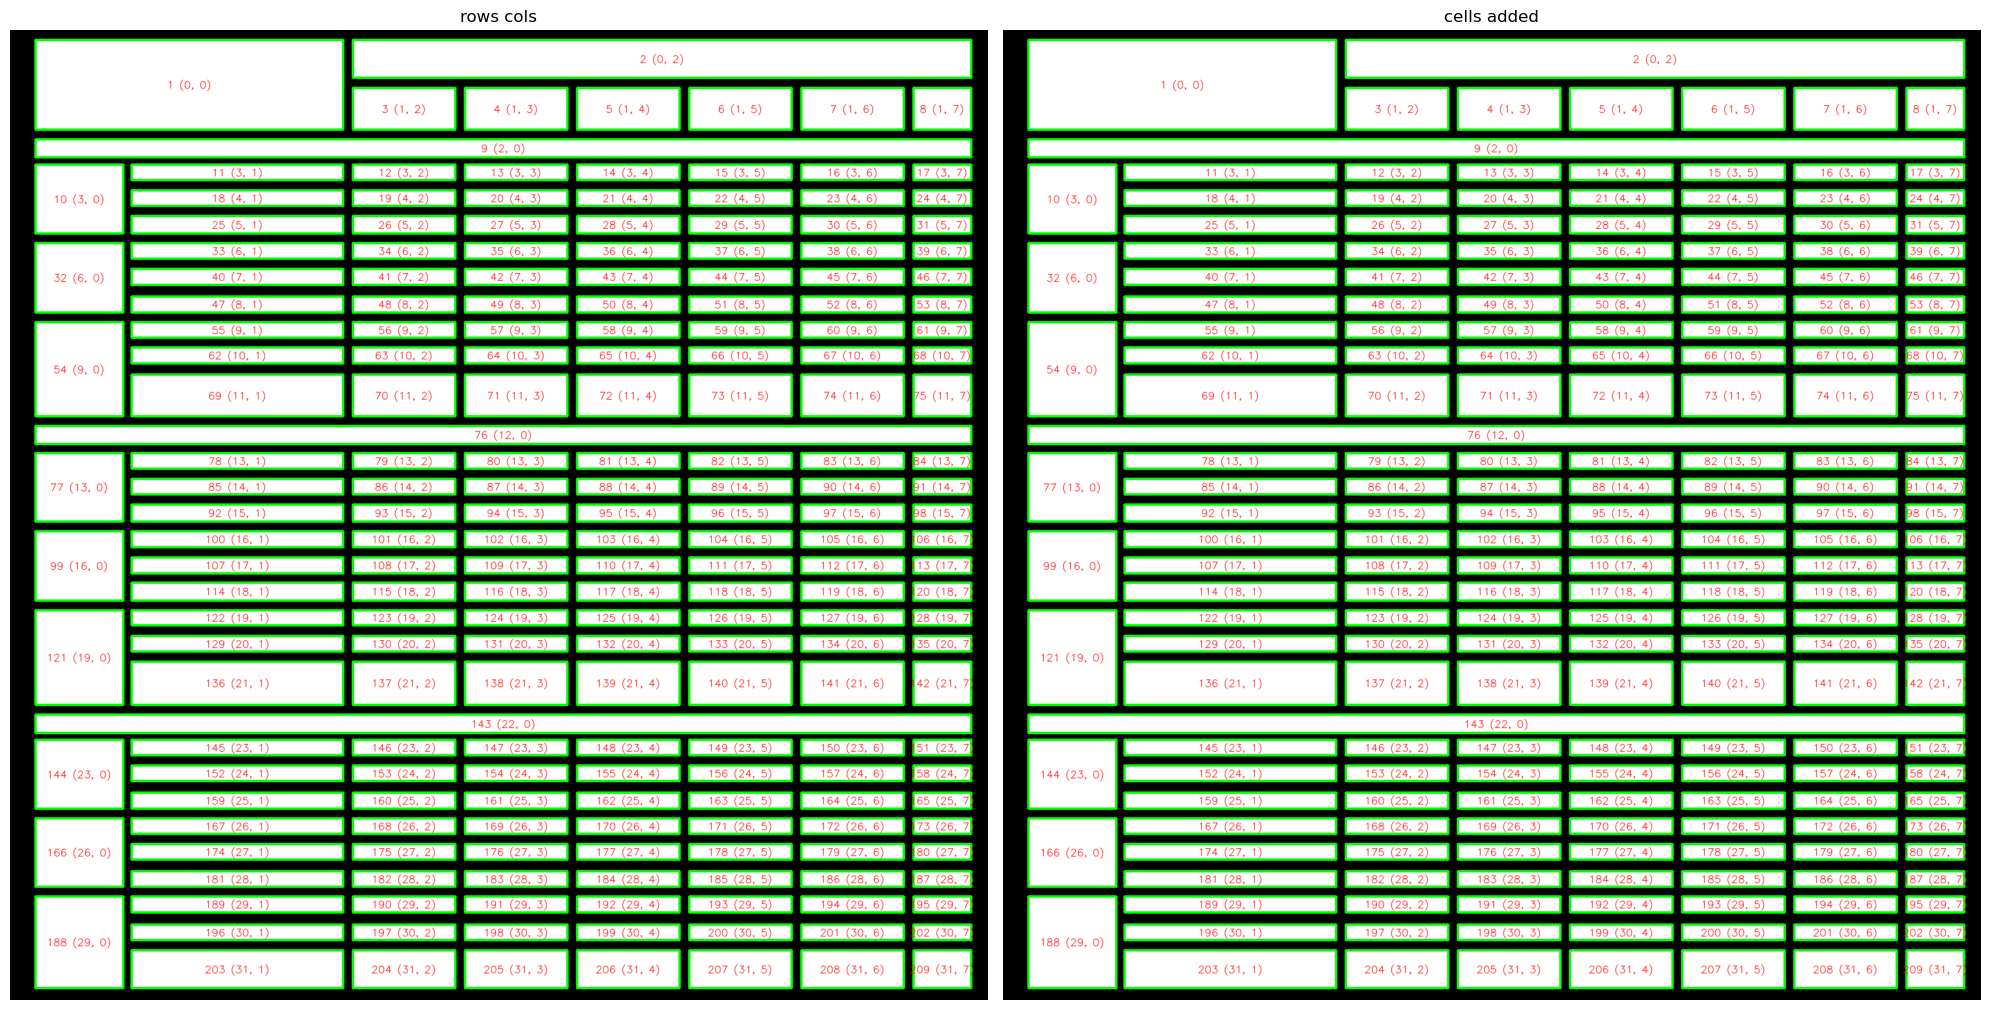

In [48]:
def add_missing_cells(bboxs, rows, cols, box_indexs):
    matrix = [[None for col in cols] for row in rows]
    for index, span in enumerate(box_indexs):
        matrix[span[0]][span[1]] = index
    # Duyệt qua toàn bộ matrix, nếu có ô nào là None thì thêm vào bboxs
    for i, row in enumerate(matrix):
        for j, cell in enumerate(row):
            if cell is None:
                row_height = rows[i][-1][3] - rows[i][-1][1]
                col_width = cols[j][-1][2] - cols[j][-1][0]
                cel_x1, cel_y1 = cols[j][-1][0], rows[i][-1][1]
                cel_x2, cel_y2 = cel_x1 + col_width, cel_y1 + row_height
                # tạo bbox mới
                new_bbox = (cel_x1, cel_y1, cel_x2, cel_y2)
                # kiểm tra xem bbox mới có nằm chồng lên bbox cùng hàng hoặc cùng cột không dựa vào x1, y1, x2, y2 của nó                
                if is_bboxs_overlap(new_bbox, bboxs): continue
                bboxs.append(new_bbox)
                # cập nhật lại rows, cols, box_indexs
                rows[i].append(new_bbox)
                cols[j].append(new_bbox)
                box_indexs.append((i, j))
    #sắp xếp lại bboxs theo thứ tự từ trên xuống dưới, từ trái qua phải
    bboxs = sorted(bboxs, key=lambda box: box[1] * 1000000 + box[0])
    box_indexs = [getbox_index(box, rows, cols) for box in bboxs]
    return bboxs, rows, cols, box_indexs

boxs, rows, cols, box_indexs = add_missing_cells(boxs, rows, cols, box_indexs)
new_mask = create_mask_from_bboxs(image_removed, boxs)
img_cells_added = draw_bboxs(new_mask, boxs, lambda x: str(x) + ' '+ str(box_indexs[x-1]))
display_images_with_labels([(img_rows_cols, 'rows cols'),(img_cells_added, 'cells added')], (1, 2), show_axis=False)

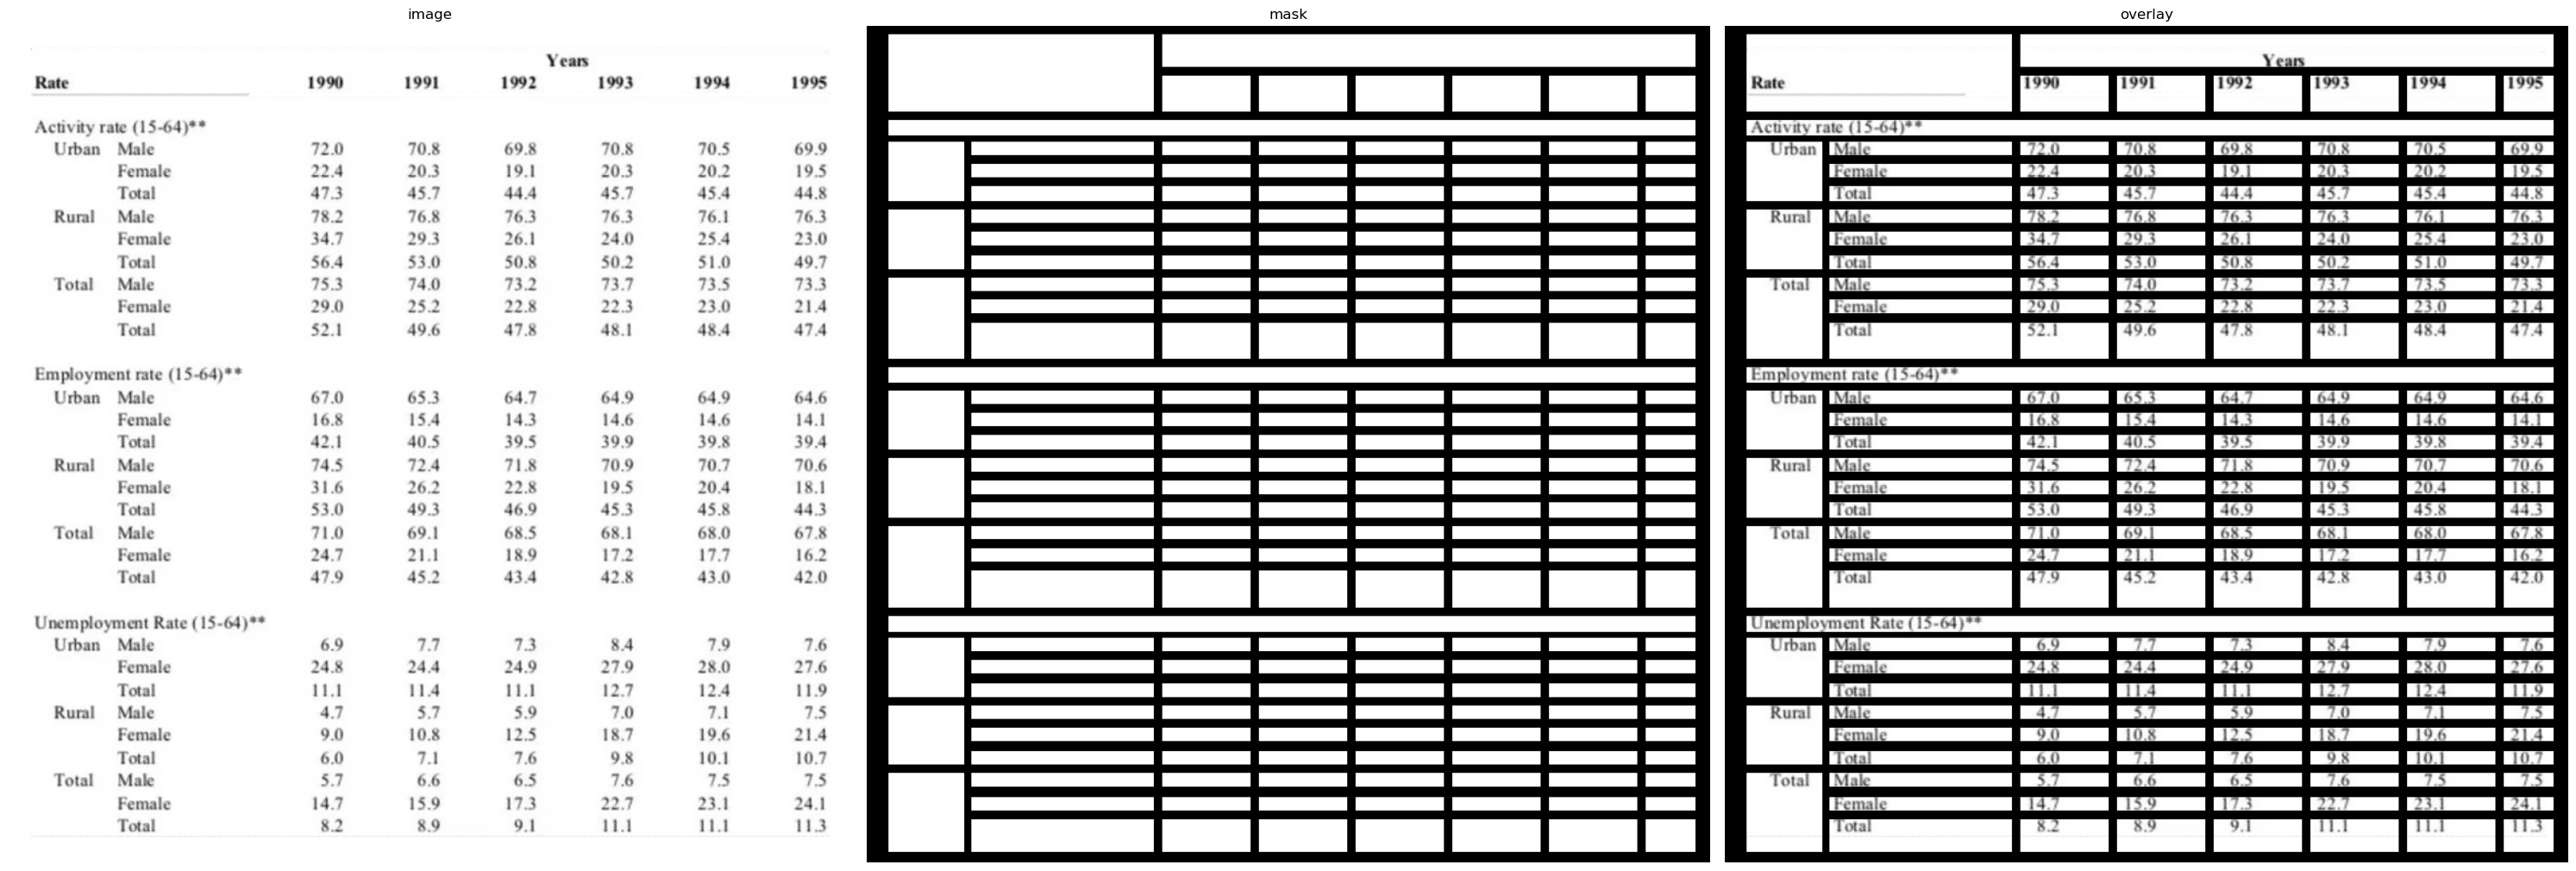

In [49]:
overlay_mask = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR) 
overlay_img = cv2.bitwise_and(image_removed, overlay_mask)
display_images_with_labels([(image_removed, 'image'),(new_mask, 'mask'),(overlay_img, 'overlay')], (1, 3), show_axis=False)

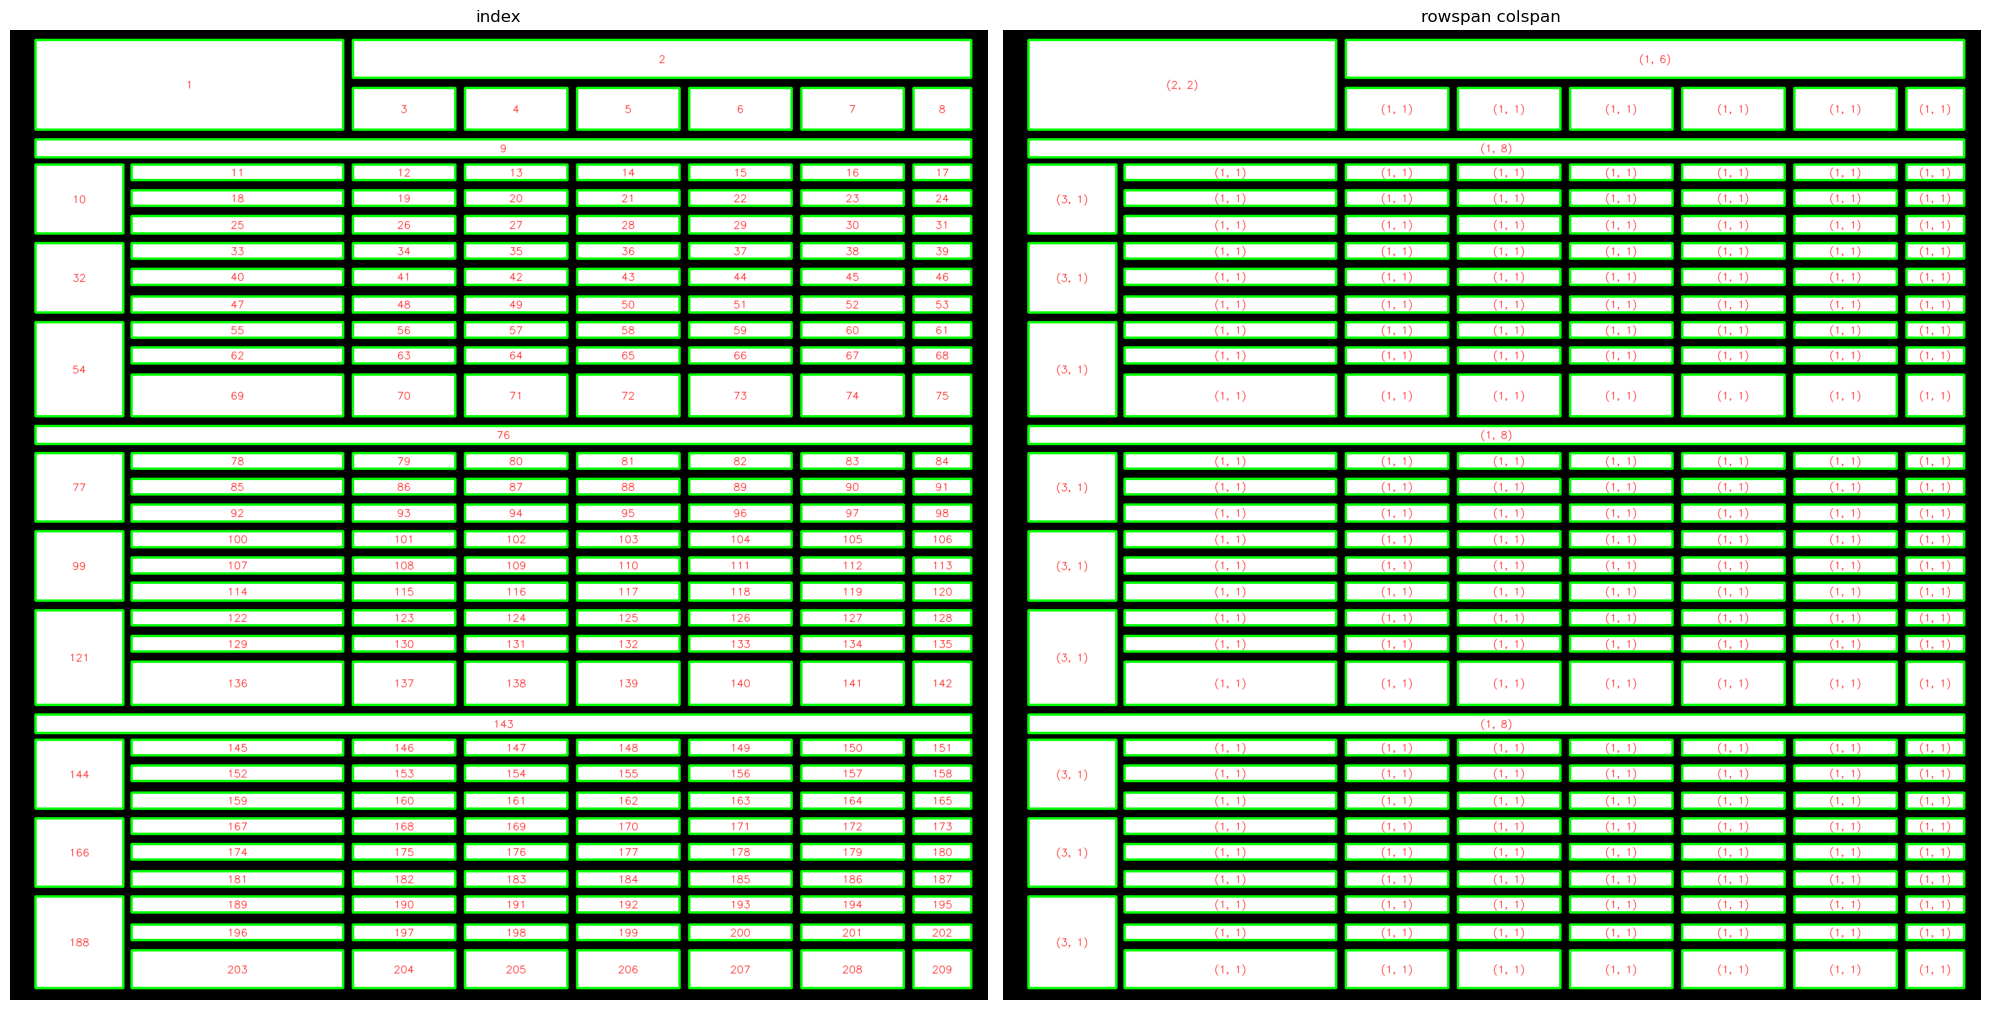

In [50]:
def createSpanMatrix(rows, cols, box_indexs, bboxs):
    matrix = [[None for col in cols] for row in rows]
    for index, span in enumerate(box_indexs):
        matrix[span[0]][span[1]] = index
    
    # Duyệt qua từng phần tử của matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] is None: continue
            box_index = matrix[i][j]
            # lấy danh sách các bbox cùng hàng với box hiện tại và khác với nó
            same_row_bboxs = [box for box in bboxs if isSameRow(box, bboxs[box_index]) and box[3] - box[1] <= bboxs[box_index][3] - bboxs[box_index][1]]
            subrows = split_rows_columns([box[:2] for box in same_row_bboxs], 'row')
            # đếm số lượng x1 khác nhau trong same_row_bboxs
            rowspan = len(subrows)
            # lấy danh sách các bbox cùng cột với box hiện tại và khác với nó
            same_col_bboxs = [box for box in bboxs if isSameCol(box, bboxs[box_index]) and box[2] - box[0] <= bboxs[box_index][2] - bboxs[box_index][0]]
            subcols = split_rows_columns([box[:2] for box in same_col_bboxs], 'col')
            # đếm số lượng y1 khác nhau trong same_col_bboxs
            colspan = len(subcols)
            matrix[i][j] = (box_index, rowspan, colspan)
    return matrix



matrix = createSpanMatrix(rows, cols, box_indexs, bboxs)
img_index= draw_bboxs(new_mask, boxs)
img_span = draw_bboxs(new_mask, boxs, lambda x: str(matrix[box_indexs[x-1][0]][box_indexs[x-1][1]][1:]))
display_images_with_labels([(img_index, 'index'),(img_span, 'rowspan colspan')], (1, 2), show_axis=False)

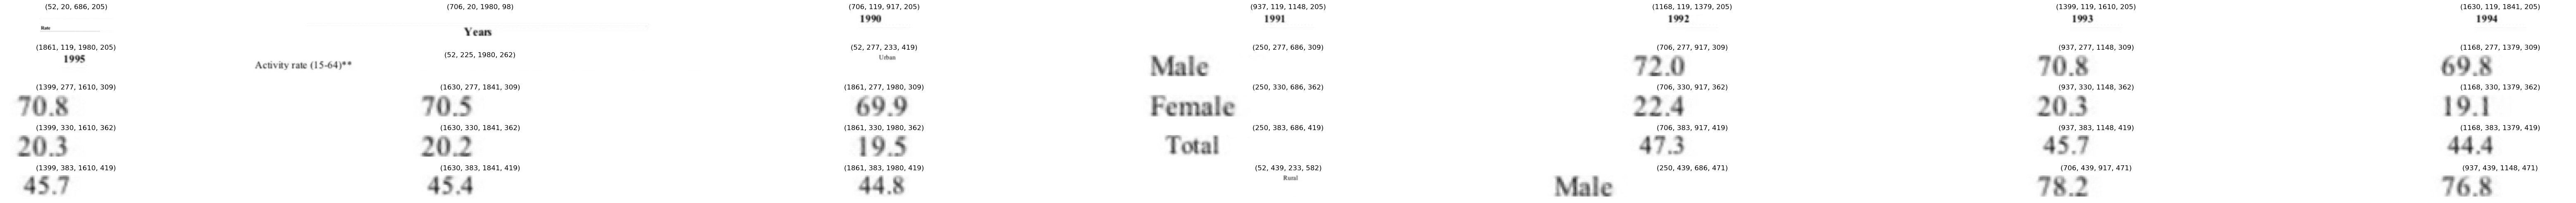

In [51]:
#@title Tạo cells và cắt các ô bảng theo các cell
# Tạo cells từ bboxs, rows, cols, box_indexs, matrix
#cell = {'bbox': bbox, 'row_span': row_span, 'col_span': col_span, 'row':row_index, 'col':col_index}
def createCells(bboxs, box_indexs, matrix):
    cells = []
    for index, bbox in enumerate(bboxs):
        row_index, col_index = box_indexs[index]
        row_span, col_span = matrix[row_index][col_index][1:]
        cell = {'bbox': bbox, 'row_span': row_span, 'col_span': col_span, 'row':row_index, 'col':col_index}
        cells.append(cell)
    return cells

def createCell_img(cell, image):
    cells_imgs = []
    img_ok = image.copy()
    for cell in cells:
        x1,y1,x2,y2 = cell['bbox']
        # img_ok = cv2.cvtColor(image_removed, cv2.COLOR_BGR2GRAY)
        # img_ok = cv2.threshold(img_ok, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # chuyển lại sang ảnh màu
        # img_ok = cv2.cvtColor(img_ok[1], cv2.COLOR_GRAY2BGR)

        cropped_image = img_ok[int(y1):int(y2), int(x1):int(x2)]
        # resize về kích thước chiều nhỏ nhất là 50
        w,h = cropped_image.shape[:2]
        if w < h:
          scale_percent = 50 / cropped_image.shape[0]
        else:
          scale_percent = 50 / cropped_image.shape[1]
        
        width = int(cropped_image.shape[1] * scale_percent)
        height = int(cropped_image.shape[0] * scale_percent)
        cropped_image = cv2.resize(cropped_image, (width, height), interpolation=cv2.INTER_AREA)

        # thêm 5px padding vào mỗi cạnh
        cropped_image = cv2.copyMakeBorder(cropped_image, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        
        cells_imgs += [(cropped_image, cell['bbox'])]
    return cells_imgs

cells = createCells(boxs, box_indexs, matrix)
cells_imgs = createCell_img(cells, image_removed)

display_images_with_labels(cells_imgs[:35], layout = (5, 7), size = (10, 1), show_axis=False)

In [52]:
#@title Cài đặt thư viện nhận diện văn bản
#Kiểm tra hiện tại đã cài đặt thư viện hay chưa
try:
    from vietocr.tool.predictor import Predictor
    print("Đã cài đặt thư viện nhận diện văn bản")
except ModuleNotFoundError:
    print("Đang cài đặt thư viện nhận diện văn bản...")
    ! pip install --quiet vietocr
finally:
    from vietocr.tool.predictor import Predictor
    from vietocr.tool.config import Cfg
    config = Cfg.load_config_from_name('vgg_seq2seq')
    # config['weights'] = './weights/transformerocr.pth'
    # config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
    config['cnn']['pretrained']=False
    config['device'] = 'cpu'
    config['predictor']['beamsearch']=False
    detector = Predictor(config)

Đã cài đặt thư viện nhận diện văn bản
Model weight C:\Users\LHONCH~1\AppData\Local\Temp\vgg_seq2seq.pth exsits. Ignore download!


1995


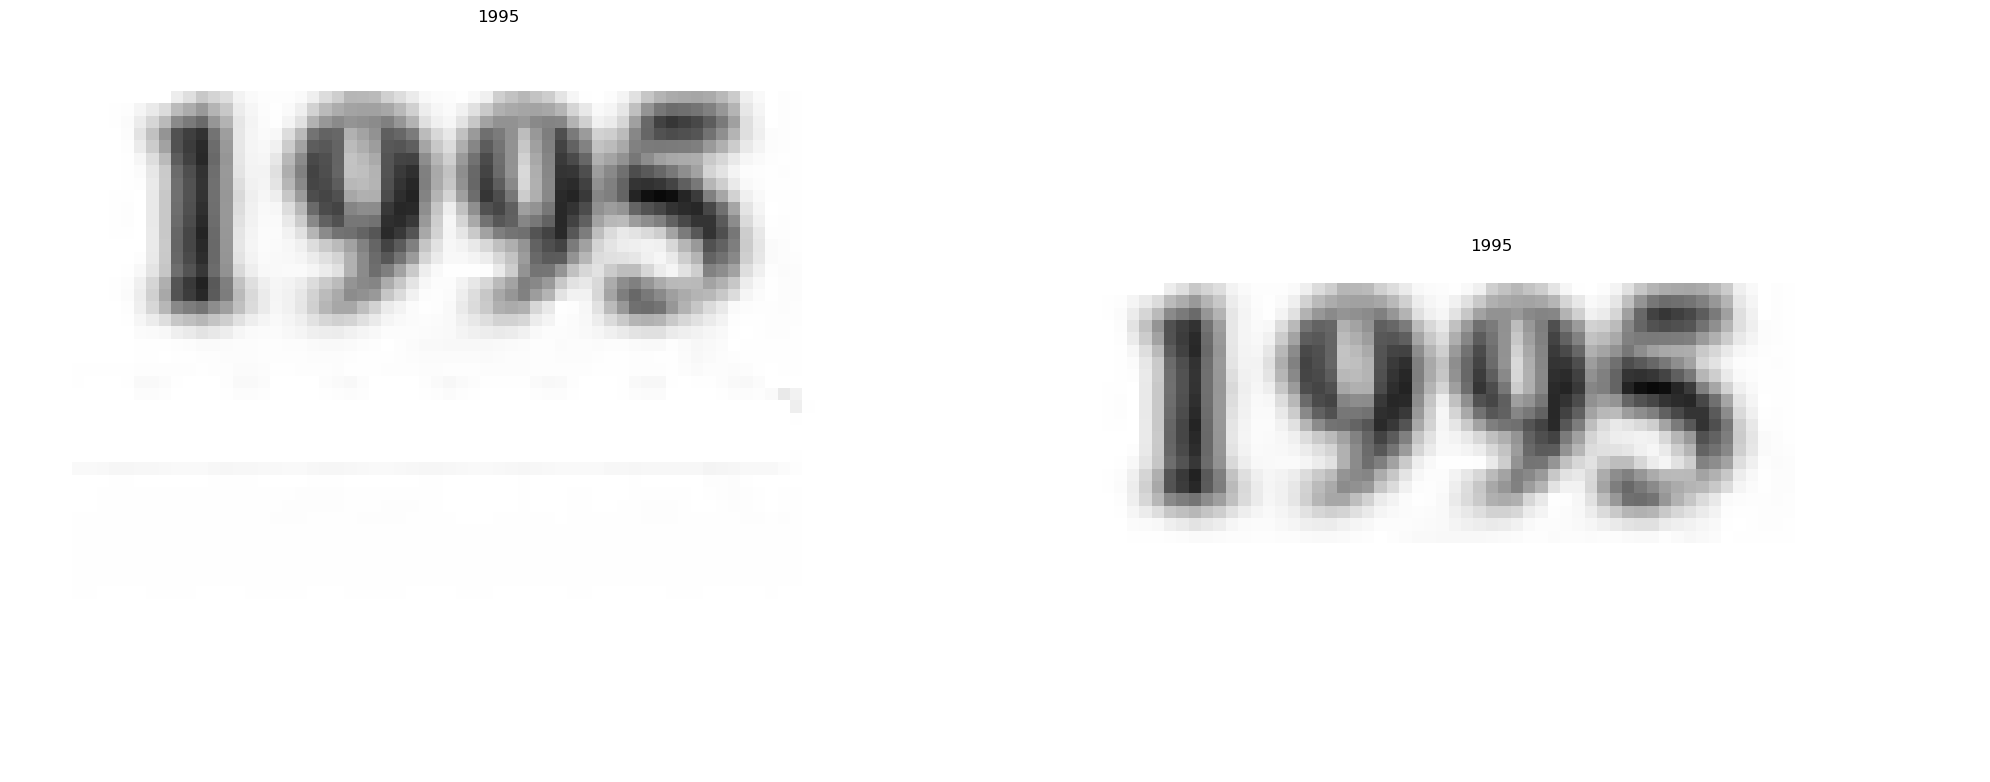

In [53]:
#@title Nhận diện văn bản trong các ô bảng

from PIL import Image

def process_image(image):
    """
    Cắt các dòng văn bản từ ảnh.

    Tham số:
    - image: Ảnh cần xử lý.

    Trả về:
    - images: Danh sách các dòng văn bản đã cắt được.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    dilated = cv2.dilate(bw, kernel, iterations=10) # mở rộng để lấp đầy hàng
    # return [dilated]
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    images = []
    # img_cnt = image.copy()
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        if area > 100 and w > h and h > 5:
            # cv2.drawContours(img_cnt, contours, -1, (0, w%255, 0), 2)
            cropped = image[y-3:y+h+3, x:]
            images+=[cropped]
    # return [img_cnt]
    if len(images) == 0:
        return []
    # Tìm độ cao lớn nhất của các ảnh
    max_height = max([img.shape[0] for img in images])
    # xoá các image có độ cao nhỏ hơn nhiều so với max_height
    images = [img for img in images if img.shape[0] > max_height / 2]
    return images[::-1]

def detectText(image):
  """
  Nhận diện văn bản trong ảnh.

  Tham số:
  - image: Ảnh cần nhận diện văn bản.

  Trả về:
  - texts: Danh sách các dòng văn bản đã nhận diện được.
  """
  lines = process_image(image)
  if len(lines) == 0:
    return "", lines
  texts = []
  for line in lines:
    try:
      image = Image.fromarray(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
      text = detector.predict(image)
      texts.append(text)
    except:
      texts.append('')
  texts = '\n'.join(texts)
  return texts , lines

img = cells_imgs[7][0]
text, lines = detectText(img)
print(text)
display_images_with_labels([(img, text)] + list(zip(lines, text.split('\n'))), (1, len(lines)+1), show_axis=False)

In [54]:
#@title Nhận diện văn bản trong tất cả các ô bảng

texts = []
for cell in cells_imgs:
  img, bbox = cell
  # text, lines = detectText(img)
  texts += ['xxx'] #[text]

print(texts, sep='\n')

['xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx'

In [55]:
import xml.etree.ElementTree as ET
def cells_to_html(cells):

    table = ET.Element("table")
    current_row = -1

    for cell in cells:
        this_row = cell['row']

        attrib = {}
        colspan = cell['col_span']
        if colspan > 1:
            attrib['colspan'] = str(colspan)
        rowspan = cell['row_span']
        if rowspan > 1:
            attrib['rowspan'] = str(rowspan)
        if this_row > current_row:
            current_row = this_row
            if current_row == 0:
                cell_tag = "th"
                row = ET.SubElement(table, "thead")
            else:
                cell_tag = "td"
                row = ET.SubElement(table, "tr")
        tcell = ET.SubElement(row, cell_tag, attrib=attrib)
        tcell.text = cell['cell text']

    return str(ET.tostring(table, encoding="unicode", short_empty_elements=False))

for i in range(len(cells)):
  cells[i]['cell text'] =  texts[i]
html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")
html

'<table><tr><th colspan="2" rowspan="2">xxx</th><th colspan="6">xxx</th></tr><tr><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td colspan="8">xxx</td></tr><tr><td rowspan="3">xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td rowspan="3">xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td rowspan="3">xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td></tr><tr><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</td><td>xxx</t

In [56]:
from IPython.display import display, HTML

css = """
table {
  border-collapse: collapse;
  border-spacing: 0;
  width: 100%;
  font-family: sans-serif;
}

th, td {
  padding: 8px;
  text-align: center;
  vertical-align: middle;
}

th {
  font-weight: bold;
  font-size: 1.2em;
}

tr:nth-child(even) {
  background-color: rgba(68, 68, 68, 0.2);
}

table th, table td {
  border: 1px solid rgba(68, 68, 68, 0.5);
}
"""
body = """
<div style="display: flex;">
  <div style="flex: 1;">
    <img src='""" + image_path + """' alt="Ảnh" style="width: 90%;">
  </div>
  <div style="flex: 1;">""" + html + """</div>
</div>
"""
new_html = '<head><style>'+ css +'</style></head><body>'+ body + '</body>'

display(HTML(new_html))

In [57]:
def recognize(image_path): 
    image = cv2.imread(image_path)
    # resize về width = 1000
    # scale_percent = 1000 / image.shape[1]
    # width = int(image.shape[1] * scale_percent)
    # height = int(image.shape[0] * scale_percent)
    # image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    image_deskew, calc_angle = deskew_image(image)
    image_ok = trim_white(image_deskew)
    mask, dots, outImag = find_Lines(image_ok)
    image_removed = remove_regions(image_ok, mask)
    bboxs, mask, outImag = find_Cells(image_removed)
    boxs = bboxs
    cols = split_box_rows_columns(boxs, mode = 'col')       
    rows = split_box_rows_columns(boxs, mode = 'row')
    box_indexs = [getbox_index(box, rows, cols) for box in boxs]
    boxs, rows, cols, box_indexs = add_missing_cells(boxs, rows, cols, box_indexs)
    matrix = createSpanMatrix(rows, cols, box_indexs, bboxs)
    cells = createCells(boxs, box_indexs, matrix)
    cells_imgs = createCell_img(cells, image_removed)
    print(len(cells_imgs), len(cells))
    texts = []
    for cell in cells_imgs:
      img, bbox = cell
      # text, lines = detectText(img)
      texts += ['xxx'] #[text]
    for i in range(len(cells)):
      cells[i]['cell text'] =  texts[i]
    html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")

    css = """
    table {
      border-collapse: collapse;
      border-spacing: 0;
      width: 100%;
      font-family: sans-serif;
    }

    th, td {
      padding: 8px;
      text-align: center;
      vertical-align: middle;
    }

    th {
      font-weight: bold;
      font-size: 1.2em;
    }

    tr:nth-child(even) {
      background-color: rgba(68, 68, 68, 0.2);
    }

    table th, table td {
      border: 1px solid rgba(68, 68, 68, 0.5);
    }
    """
    body = """
    <div style="display: flex;">
      <div style="flex: 1;">
        <img src='""" + image_path + """' alt="Ảnh" style="width: 90%;">
      </div>
      <div style="flex: 1;">""" + html + """</div>
    </div>
    """
    new_html = '<head><style>'+ css +'</style></head><body>'+ body + '</body>'

    return new_html


prePath = "/content/TableVision/" if IN_COLAB else ""
display(HTML(recognize(prePath + "sample/no4.jpg")))

209 210


IndexError: list index out of range